# ----------------------------------------------
# 📊 IPL 2024–2025 Analysis
# Description: Local CSV-based analysis of IPL data filtered by seasons 2024 and 2025
# Author: [Chirag Suri]
# ----------------------------------------------

## Importing Libraries and uploading datasets

In [97]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
# Load IPL filtered dataset (raw ball-by-ball for 2024 & 2025)

In [99]:
ipl_filtered = pd.read_csv(
    'G:/WEBD CODES/DA Projects/IPL/Dataset/ipl_filtered_24_25.csv',
    low_memory=False
)

In [100]:
# Low memory false disables internal chunking and lets pandas infer types more accurately across the full dataset.

In [101]:
# Load cleaned player-level stats (1 row per ball)

In [102]:
ipl_player_stats = pd.read_csv(
    'G:/WEBD CODES/DA Projects/IPL/Dataset/ipl_player_stats_24_25.csv',
    low_memory=False
)

In [103]:
# Load match-level summary (1 row per match)

In [104]:
ipl_summary = pd.read_csv(
    'G:/WEBD CODES/DA Projects/IPL/Dataset/ipl_summary_24_25.csv',
    low_memory=False
)

## ✅ Confirm loaded shapes

In [105]:
print("Filtered (Raw Ball-by-Ball):", ipl_filtered.shape)
print("Cleaned Player Stats:", ipl_player_stats.shape)
print("Match Summary:", ipl_summary.shape)

Filtered (Raw Ball-by-Ball): (34388, 35)
Cleaned Player Stats: (32815, 12)
Match Summary: (145, 6)


In [106]:
# ✅ Peek at first few rows

In [107]:
ipl_filtered['runs_target'].dtype

dtype('float64')

## Verifying Data Types

In [108]:
print("Dtypes (Filtered):\n", ipl_filtered.dtypes, "\n")
print("Dtypes (Player Stats):\n", ipl_player_stats.dtypes, "\n")
print("Dtypes (Summary):\n", ipl_summary.dtypes, "\n")

Dtypes (Filtered):
 match_id             int64
innings              int64
batting_team        object
bowling_team        object
over_no              int64
ball                 int64
ball_no            float64
batter              object
bat_pos              int64
runs_batter          int64
batter_runs          int64
batter_balls         int64
bowler              object
bowler_wicket        int64
runs_extra           int64
runs_total           int64
extra_type          object
wicket_kind         object
player_out          object
fielders            object
runs_target        float64
team_reviewed       object
review_decision     object
player_of_match     object
match_won_by        object
win_outcome         object
toss_winner         object
toss_decision       object
venue               object
city                object
season               int64
result_type         object
event_match_no      object
stage               object
date                object
dtype: object 

Dtypes (Player Stat

In [109]:
# We see in the filtered dataset runs_target is displayed as float and date as object, we need to change that

In [110]:
# Convert runs_target to integer safely
ipl_filtered['runs_target'] = pd.to_numeric(ipl_filtered['runs_target'], errors='coerce').fillna(0).astype(int)

# Convert date column to datetime format
ipl_filtered['date'] = pd.to_datetime(ipl_filtered['date'], errors='coerce', format='%Y-%m-%d')

In [111]:
# confirming our results

In [112]:
ipl_filtered[['runs_target', 'date']].dtypes

runs_target             int64
date           datetime64[ns]
dtype: object

## 🏆 Team Win Percentage (IPL 2024 & 2025)

This analysis calculates the win percentage of each IPL team for the 2024 and 2025 seasons.

We exclude a cancelled match between **Punjab Kings** and **Delhi Capitals**, which took place on **08-May-2025** due to **Operation Sindoor**, but had:
- No result (`match_won_by = 'Unknown'`)
- No Player of the Match

Instead of using the `match_id`, we filtered it by its known characteristics:
- `toss_winner = 'Punjab Kings'`
- `toss_loser = 'Delhi Capitals'`
- `match_won_by = 'Unknown'`
- `player_of_match = 'Unknown'`
- `season = 2025`

This approach is flexible and doesn't rely on internal ID access.


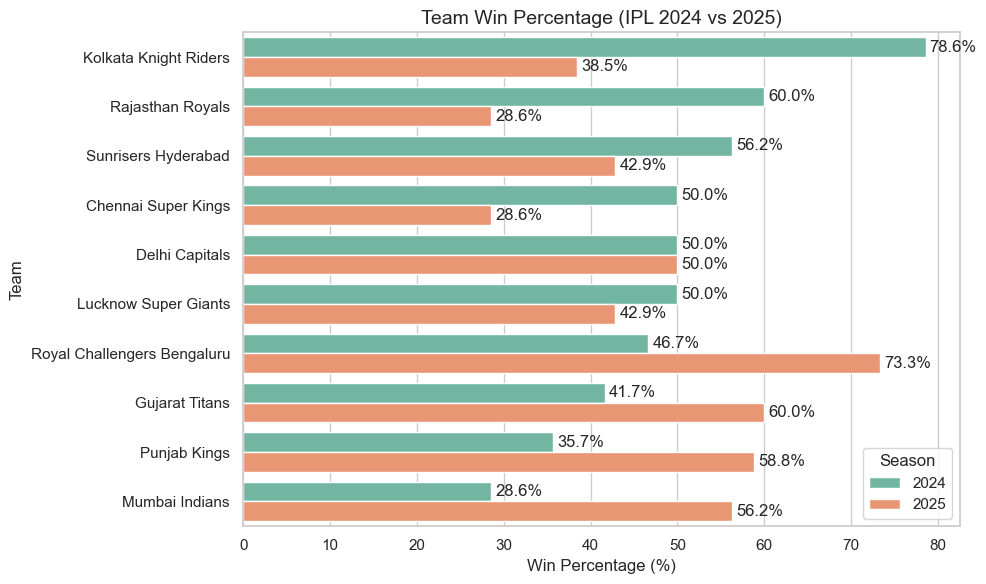

In [113]:
# 🔍 Identify the cancelled match (Punjab Kings vs Delhi Capitals in 2025, unknown result)
cancelled_match_mask = (
    (ipl_summary['toss_winner'] == 'Punjab Kings') &
    (ipl_summary['toss_loser'] == 'Delhi Capitals') &
    (ipl_summary['match_won_by'] == 'Unknown') &
    (ipl_summary['player_of_match'] == 'Unknown') &
    (ipl_summary['season'] == 2025)
)

# ❌ Exclude that cancelled match using logical filtering (no match_id used)
ipl_summary_filtered = ipl_summary[~cancelled_match_mask]

# ✅ Count total matches played by each team (by combining toss_winner and toss_loser)
team_matches = pd.concat([
    ipl_summary_filtered[['season', 'toss_winner']].rename(columns={'toss_winner': 'team'}),
    ipl_summary_filtered[['season', 'toss_loser']].rename(columns={'toss_loser': 'team'})
])

matches_played = team_matches.groupby(['season', 'team']).size().reset_index(name='matches_played')

# ✅ Count number of matches won by each team
wins = ipl_summary_filtered.groupby(['season', 'match_won_by']).size().reset_index(name='wins')
wins = wins.rename(columns={'match_won_by': 'team'})

# 🔄 Merge matches played and wins, calculate win percentage
win_df = pd.merge(matches_played, wins, on=['season', 'team'], how='left')
win_df['wins'] = win_df['wins'].fillna(0).astype(int)
win_df['win_percent'] = (win_df['wins'] / win_df['matches_played']) * 100

# 🔁 Sort for nicer plotting
win_df = win_df.sort_values(by=['season', 'win_percent'], ascending=[True, False])

# 📊 Plot as horizontal bar chart with annotations
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=win_df, 
    y='team', x='win_percent', 
    hue='season', 
    palette='Set2', 
    orient='h'
)

# Annotate bars with win percentage values
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

# 📋 Title and labels
plt.title("Team Win Percentage (IPL 2024 vs 2025)", fontsize=14)
plt.xlabel("Win Percentage (%)")
plt.ylabel("Team")
plt.legend(title="Season", loc='lower right')
plt.tight_layout()
plt.show()

## 🧤 Fielding: Total Catches Taken by Each Team (IPL 2024 & 2025)

In this section, we analyze how many successful catches each IPL team took during the 2024 and 2025 seasons.

Since our dataset does not include information about dropped catches or total chances, we do **not** calculate a "catching efficiency percentage." Instead, we focus on the **total number of successful catches** based on official dismissal records.

### ✅ Data Used:
- `ipl_player_stats_24_25.csv` → to identify all `wicket_kind = 'caught'` events
- `ipl_filtered_24_25.csv` → to associate each dismissal with the `bowling_team`

### 🔎 Method:
1. Filter dismissals where `wicket_kind == 'caught'`
2. Merge player stats with filtered match data to identify which **team** the bowler (and thus the fielder) belonged to
3. Group the data by `season` and `bowling_team`
4. Count the number of successful catches taken per team in each season


In [114]:
# 🔍 Step 1: Filter for successful catches only
caught = ipl_player_stats[ipl_player_stats["wicket_kind"] == "caught"]

# 🔗 Step 2: Merge with filtered data to get bowling_team
merged = pd.merge(
    caught,
    ipl_filtered[["match_id", "over_no", "ball", "bowler", "bowling_team"]],
    on=["match_id", "over_no", "ball", "bowler"],
    how="left"
)

# 📊 Step 3: Group by season and bowling_team to count total catches
team_catches = merged.groupby(["season", "bowling_team"]).size().reset_index(name="total_catches")

# 🔢 Sort for readability
team_catches = team_catches.sort_values(by=["season", "total_catches"], ascending=[True, False])

# 🔁 Split into two tables
catches_2024 = team_catches[team_catches["season"] == 2024].reset_index(drop=True)
catches_2025 = team_catches[team_catches["season"] == 2025].reset_index(drop=True)

# 🖨️ Show results
print("✅ IPL 2024 – Total Catches by Team")
display(catches_2024)

print("\n✅ IPL 2025 – Total Catches by Team")
display(catches_2025)

✅ IPL 2024 – Total Catches by Team


,season,bowling_team,total_catches
0,2024,Kolkata Knight Riders,79
1,2024,Royal Challengers Bengaluru,71
2,2024,Delhi Capitals,70
3,2024,Punjab Kings,70
4,2024,Rajasthan Royals,67
5,2024,Sunrisers Hyderabad,67
6,2024,Chennai Super Kings,61
7,2024,Mumbai Indians,60
8,2024,Lucknow Super Giants,58
9,2024,Gujarat Titans,53



✅ IPL 2025 – Total Catches by Team


,season,bowling_team,total_catches
0,2025,Mumbai Indians,77
1,2025,Royal Challengers Bengaluru,72
2,2025,Punjab Kings,70
3,2025,Gujarat Titans,66
4,2025,Sunrisers Hyderabad,65
5,2025,Chennai Super Kings,58
6,2025,Rajasthan Royals,58
7,2025,Lucknow Super Giants,57
8,2025,Kolkata Knight Riders,56
9,2025,Delhi Capitals,50


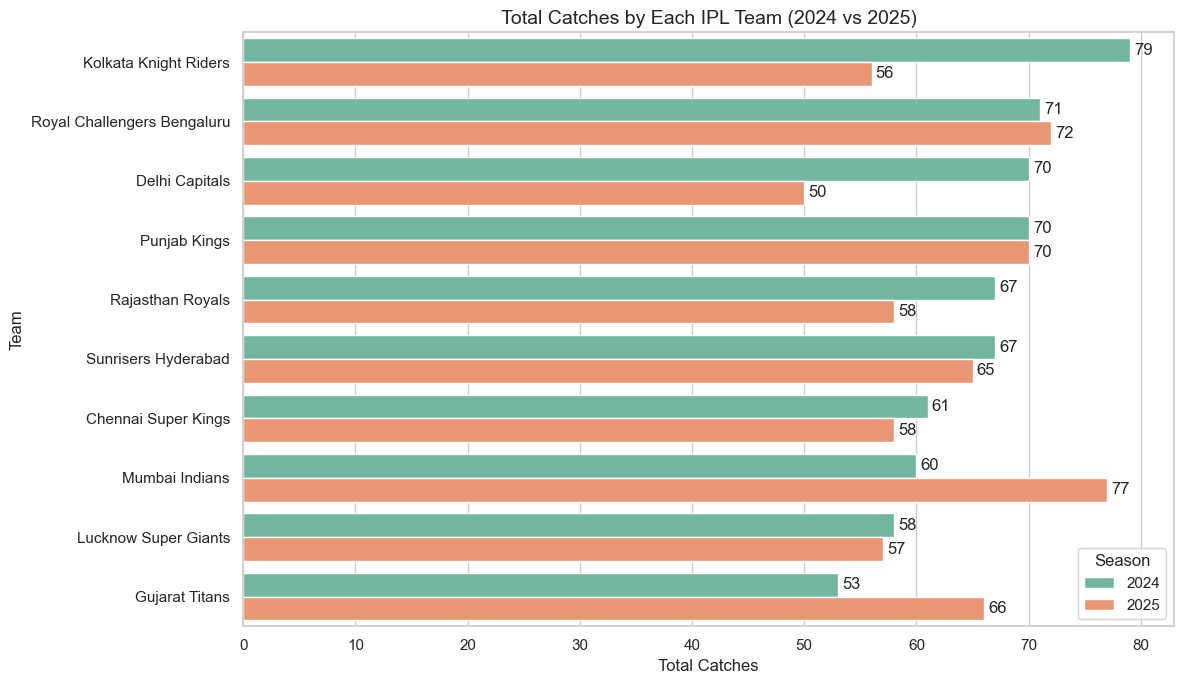

In [115]:
# 📊 Create horizontal bar plot showing total catches by team and season
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=team_catches,
    x="total_catches",
    y="bowling_team",
    hue="season",
    palette="Set2"
)

# 🔢 Add total catch count labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Set title and axis labels
plt.title("Total Catches by Each IPL Team (2024 vs 2025)", fontsize=14)
plt.xlabel("Total Catches")
plt.ylabel("Team")
plt.legend(title="Season", loc='lower right')
plt.tight_layout()

# 👁️ Show the plot
plt.show()

## 🔵 Dot Balls Bowled by Each Team (IPL 2024 & 2025)

This section calculates the total number of **dot balls** bowled by each team in the 2024 and 2025 IPL seasons.

A dot ball is defined as a legal delivery where the batting team scores **zero runs** off the bat **and** no extras are conceded. This metric reflects the bowling team's ability to apply pressure through tight, run-less deliveries.

### ✅ Logic:
- Dot Ball = `runs_batter == 0` **and** `runs_extra == 0`
- Count dot balls per team by grouping on `season` and `bowling_team`
- Display season-wise breakdown and visualize as a horizontal bar chart


In [116]:
# 🟦 Filter dot balls: zero runs from bat and extras
dot_balls = ipl_filtered[
    (ipl_filtered["runs_batter"] == 0) & 
    (ipl_filtered["runs_extra"] == 0)
]

# 📊 Group by season and bowling team, then count
dot_counts = dot_balls.groupby(["season", "bowling_team"]).size().reset_index(name="total_dot_balls")

# 🧾 Sort for cleaner presentation
dot_counts = dot_counts.sort_values(by=["season", "total_dot_balls"], ascending=[True, False])

# 🔁 Split into two season-wise tables
dot_2024 = dot_counts[dot_counts["season"] == 2024].reset_index(drop=True)
dot_2025 = dot_counts[dot_counts["season"] == 2025].reset_index(drop=True)

# 📋 Show season-wise dot ball counts
print("🟦 IPL 2024 – Dot Balls by Team")
display(dot_2024)

print("\n🟦 IPL 2025 – Dot Balls by Team")
display(dot_2025)

🟦 IPL 2024 – Dot Balls by Team


,season,bowling_team,total_dot_balls
0,2024,Kolkata Knight Riders,597
1,2024,Rajasthan Royals,570
2,2024,Royal Challengers Bengaluru,554
3,2024,Sunrisers Hyderabad,552
4,2024,Chennai Super Kings,551
5,2024,Punjab Kings,539
6,2024,Lucknow Super Giants,527
7,2024,Mumbai Indians,525
8,2024,Delhi Capitals,524
9,2024,Gujarat Titans,429



🟦 IPL 2025 – Dot Balls by Team


,season,bowling_team,total_dot_balls
0,2025,Mumbai Indians,658
1,2025,Punjab Kings,578
2,2025,Gujarat Titans,575
3,2025,Royal Challengers Bengaluru,570
4,2025,Chennai Super Kings,537
5,2025,Kolkata Knight Riders,497
6,2025,Delhi Capitals,493
7,2025,Sunrisers Hyderabad,492
8,2025,Rajasthan Royals,472
9,2025,Lucknow Super Giants,468


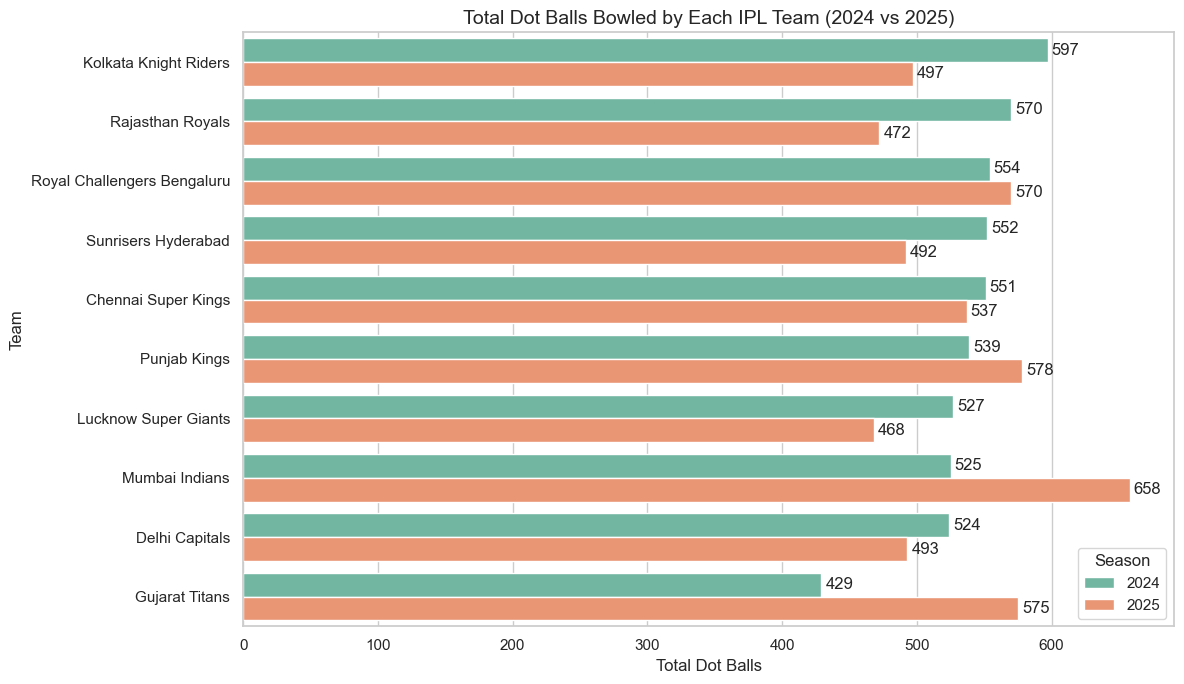

In [117]:
# 📈 Horizontal bar plot for dot balls by team and season
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=dot_counts,
    x="total_dot_balls",
    y="bowling_team",
    hue="season",
    palette="Set2"  # Categorical, visually distinct
)

# 🔢 Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# ✅ Set title and axis labels
plt.title("Total Dot Balls Bowled by Each IPL Team (2024 vs 2025)", fontsize=14)
plt.xlabel("Total Dot Balls")
plt.ylabel("Team")
plt.legend(title="Season", loc='lower right')
plt.tight_layout()

# 👁️ Show plot
plt.show()

## 💥 Fours and Sixes Hit by Each Team (IPL 2024 & 2025)

This section analyzes the attacking performance of teams in the IPL by counting how many **fours (4s)** and **sixes (6s)** they hit in each season.

By grouping scoring events by team and season, we can identify the most aggressive batting sides and how their boundary-hitting evolved over time.

### ✅ Logic:
- A **four** is when `runs_batter == 4`
- A **six** is when `runs_batter == 6`
- Group by `batting_team` and `season` to count each
- Present season-wise tables and visualize as a grouped bar chart


In [118]:
# 🔍 Filter for fours and sixes
fours = ipl_filtered[ipl_filtered["runs_batter"] == 4]
sixes = ipl_filtered[ipl_filtered["runs_batter"] == 6]

# 📊 Group by season and team, count fours and sixes
fours_count = fours.groupby(["season", "batting_team"]).size().reset_index(name="total_fours")
sixes_count = sixes.groupby(["season", "batting_team"]).size().reset_index(name="total_sixes")

# 🔗 Merge the counts into one DataFrame
boundary_counts = pd.merge(fours_count, sixes_count, on=["season", "batting_team"], how="outer").fillna(0)
boundary_counts["total_fours"] = boundary_counts["total_fours"].astype(int)
boundary_counts["total_sixes"] = boundary_counts["total_sixes"].astype(int)

# 🧾 Sort and split season-wise
boundary_counts = boundary_counts.sort_values(by=["season", "total_sixes", "total_fours"], ascending=[True, False, False])
boundary_2024 = boundary_counts[boundary_counts["season"] == 2024].reset_index(drop=True)
boundary_2025 = boundary_counts[boundary_counts["season"] == 2025].reset_index(drop=True)

# 📋 Display tables
print("💥 IPL 2024 – Total Fours and Sixes by Team")
display(boundary_2024)

print("\n💥 IPL 2025 – Total Fours and Sixes by Team")
display(boundary_2025)

💥 IPL 2024 – Total Fours and Sixes by Team


,season,batting_team,total_fours,total_sixes
0,2024,Sunrisers Hyderabad,217,178
1,2024,Royal Challengers Bengaluru,229,165
2,2024,Kolkata Knight Riders,238,141
3,2024,Delhi Capitals,229,135
4,2024,Mumbai Indians,215,133
5,2024,Punjab Kings,213,120
6,2024,Rajasthan Royals,236,112
7,2024,Chennai Super Kings,209,107
8,2024,Lucknow Super Giants,206,102
9,2024,Gujarat Titans,183,68



💥 IPL 2025 – Total Fours and Sixes by Team


,season,batting_team,total_fours,total_sixes
0,2025,Punjab Kings,267,179
1,2025,Lucknow Super Giants,218,152
2,2025,Rajasthan Royals,211,146
3,2025,Mumbai Indians,260,143
4,2025,Royal Challengers Bengaluru,239,125
5,2025,Gujarat Titans,256,124
6,2025,Sunrisers Hyderabad,219,120
7,2025,Delhi Capitals,221,110
8,2025,Chennai Super Kings,199,102
9,2025,Kolkata Knight Riders,173,101


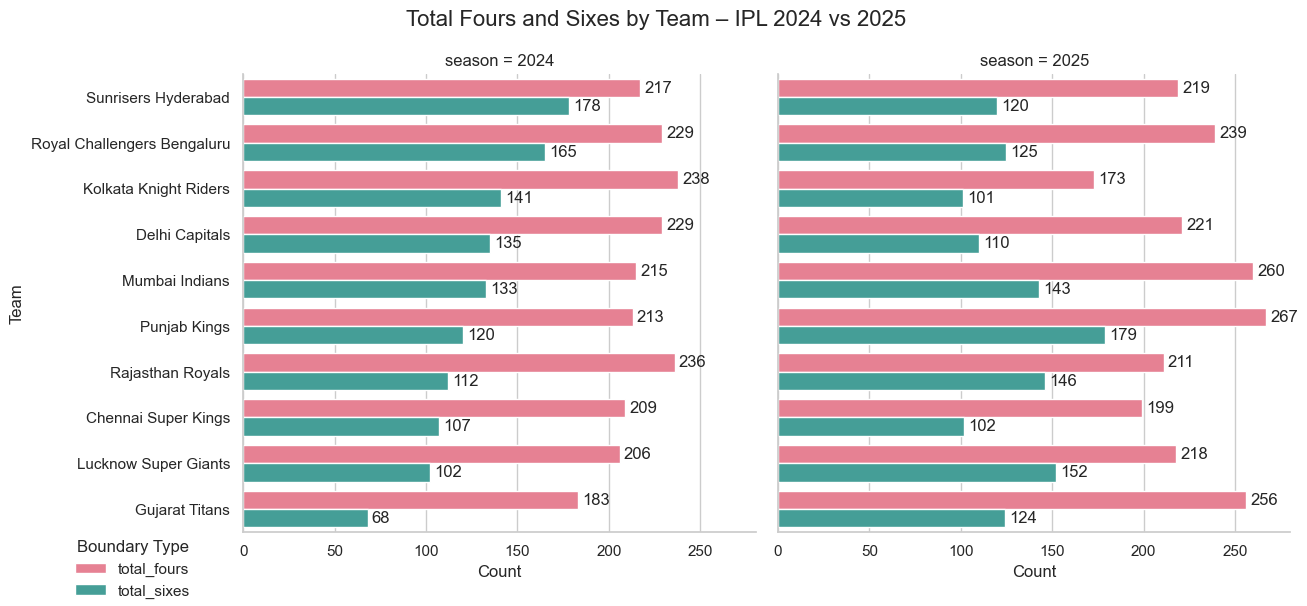

In [119]:
# 🔄 Reshape boundary_counts into long format for plotting
boundary_melted = pd.melt(
    boundary_counts,
    id_vars=["season", "batting_team"],
    value_vars=["total_fours", "total_sixes"],
    var_name="boundary_type",
    value_name="count"
)

# 🪄 Side-by-side bar charts by season
g = sns.catplot(
    data=boundary_melted,
    kind="bar",
    x="count",
    y="batting_team",
    hue="boundary_type",
    col="season",
    palette="husl",
    height=6,
    aspect=1
)

# 🔢 Add value labels to bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# 📊 Title and layout adjustments
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Total Fours and Sixes by Team – IPL 2024 vs 2025", fontsize=16)
g.set_axis_labels("Count", "Team")
g._legend.set_title("Boundary Type")

# Move legend below the plot
g._legend.set_title("Boundary Type")
g._legend.set_bbox_to_anchor((0.1, -0.01))
g._legend.set_loc("lower center")

plt.tight_layout()
plt.show()

## 🪙 Toss Winner Impact on Match Result (IPL 2024 & 2025)

In this section, we analyze how often the team that won the toss also went on to win the match.

This helps us answer the popular question:
> "Does winning the toss give a real advantage in IPL matches?"

We exclude:
- Matches with missing winner/toss data
- Replayed or abandoned games

### ✅ Logic:
- Compare `toss_winner` with `match_won_by`
- If equal → toss winner also won the match
- Calculate percentage and visualize using pie charts

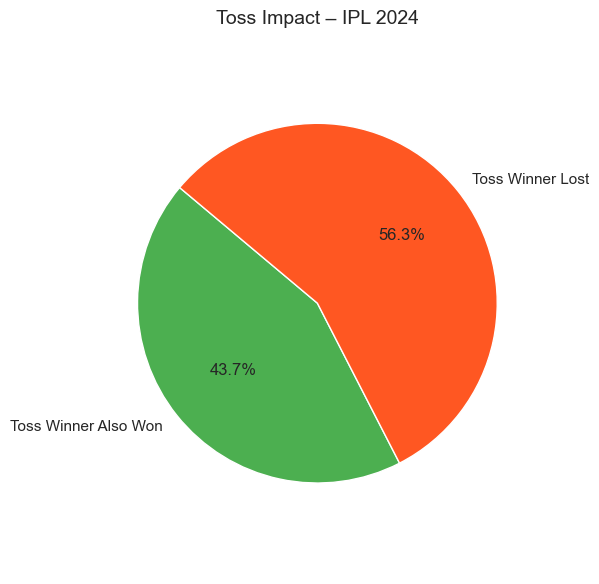

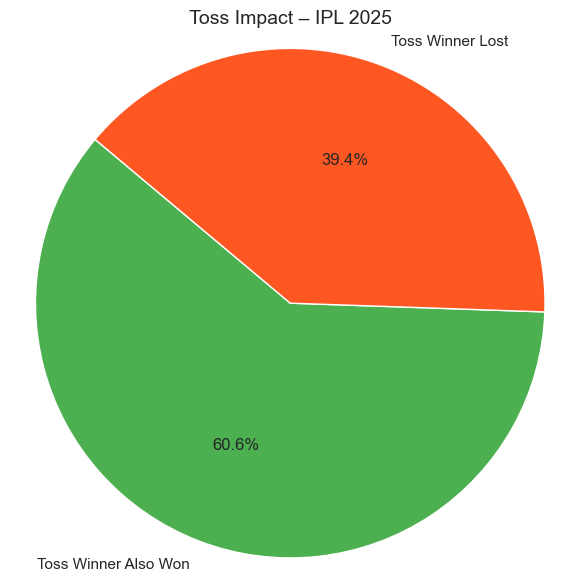

In [120]:
# 🔍 Exclude matches with missing toss or match winner
valid_matches = ipl_summary[
    ipl_summary["toss_winner"].notna() & 
    ipl_summary["match_won_by"].notna() &
    (ipl_summary["toss_winner"] != "Unknown") &
    (ipl_summary["match_won_by"] != "Unknown")
].copy()

# 🎯 Create flag: did toss winner also win match?
valid_matches["toss_win_match_win"] = valid_matches["toss_winner"] == valid_matches["match_won_by"]

# 📊 Group by season and get counts
toss_impact = valid_matches.groupby(["season", "toss_win_match_win"]).size().reset_index(name="count")

# 🔁 Loop through each season and plot pie charts
for season in toss_impact["season"].unique():
    season_data = toss_impact[toss_impact["season"] == season]
    
    # Labels for pie chart
    labels = ["Toss Winner Also Won", "Toss Winner Lost"]
    sizes = [
        season_data[season_data["toss_win_match_win"] == True]["count"].values[0],
        season_data[season_data["toss_win_match_win"] == False]["count"].values[0]
    ]
    
    # 🎨 Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=["#4CAF50", "#FF5722"])
    plt.title(f"Toss Impact – IPL {season}", fontsize=14)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()